
## Bayesian updating for the (NFL) win 🏈

Silver's Elo model maintains a running metric of team ability, $Elo_{tm}$, that updates after every game. Here is <a href="https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/">his formula</a> and
<a href="https://github.com/fivethirtyeight/nfl-elo-game/blob/master/forecast.py">source code</a>. The number is used to estimate win probability in almost the same way as you'd use the result from a logistic regression:

$$
Pr(\text{team A wins}) = \frac{1}{10^{-(Elo_A - Elo_B)/400} + 1}
$$

### Copy Silver's approach, but use a different model

The FiveThirtyEight Elo approach is intuitive and simple:

1. Start with a baseline value for team skill
2. Update the Elo numbers every week
3. At the end of each season revert the values back to the mean

This post will do the same thing, but will be updating <span class="vocabulary" title="Hyperparameters are parameters for the conjugate prior distribution. Given the observed data, you can calculate the hyperparameters for the posterior predictive distribution. They're named hyperparameters to distinguish them from the parameters of the likelihood function.">hyperparameters</span> of known distributions rather than the Elo parameters FiveThirtyEight used. I want to only select from distributions that have analytic solutions. <a href="https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions">This table on Wikipedia</a> lists those in the exponential family, with columns for the <span class="vocabulary" title="The likelihood function has the exact same formula as a probability density function except that the random variable takes fixed values based on actual observations and the model parameters can be varied to provide the maximum likelihood.">likelihood</span>, its <span class="vocabulary" title="In Bayesian alanysis, the conjugate prior to a likelihood is a distribution that, in combination with the likelihood, yields an analytic posterior predictive distribution.">conjugate prior</span>, and their <span class="vocabulary" title="In Bayesian analysis, the posterior predictive distribution is the model—it's combines prior intuition with all available evidence.">posterior distribution</span>. The two models selected for this blog post are:

* **<a href="#Bernoulli-distribution">A Bernoulli posterior</a>** to predict win probability<br/>
  ⇒ A running tally of wins vs. losses for each team is all you need.
* **<a href="#T-distribution">A <span class="vocabulary" title="So this story is on Wikipedia but it's too good to not repeat: the guy's name is not 'Student', obviously, but he was a statistician working for Guinness—yes, the beer company—back in the day. They must have wanted perfect beer. Anyway, to not reveal who he was and thus tip off competitors that they had some crack genius doing quality control on their beer, he had to publish under the pen name 'Student'. Awesome, right? We can drink to that.">Student's T</span> posterior</a>** to predict point spread<br/>
  ⇒ A running game count, mean spread, and variance are all for this model. The theory depends on every future outcome being independent of previous outcomes, which is true so we're fine.


## Data

FiveThirtyEight's <a href="https://github.com/fivethirtyeight/nfl-elo-game">GitHub repository</a> contains a cleaned dataset of historical scores that date back to 1920. We can use to develop the algorithm. The column named "neutral" has two values: "neutral&nbsp;==&nbsp;1" means the game is on neutral ground (no home field advantage), and "neutral&nbsp;==&nbsp;0" means the home field advantage goes to "team1". The rest of the column names are straightforward. The goal is to make an online-updating model like FiveThirtyEight's Elo using only prior scores, team, and home field advantage.


### Initial setup

This blog post is an executable Jupyter notebook. You can reproduce everything by re-running <a href="https://github.com/tanyaschlusser/tanyaschlusser.github.io/blob/src/posts/bayesian-updating-and-the-nfl.ipynb">the original notebook</a>. This first cell does the standard imports, then pulls the data from FiveThirtyEight.

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import seaborn as sns
import scipy.stats as stats
from collections import OrderedDict
from matplotlib.pyplot import xlabel

sns.set_context("notebook")
sns.set_style("white")

In [128]:
url1 = 'https://github.com/fivethirtyeight/nfl-elo-game/raw/master/data/nfl_games.csv'
url2 = 'https://projects.fivethirtyeight.com/nfl-api/2021/nfl_games_2021.csv'

df = pd.concat((pd.read_csv(__, low_memory=False) for __ in [url1, url2]), ignore_index = True)
df['spread'] = df['score1'] - df['score2']

print(f'Total teams in the dataset: {len(df.team1.unique())}')
print(f'Total teams after 1980: {len(df[df.season > 1980].team1.unique())}')

df.head(5)

Total teams in the dataset: 101
Total teams after 1980: 32


,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,spread
0,1920-09-26,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0,48
1,1920-10-03,1920,0,0,AKR,WHE,1503.420,1300.000,0.824212,43,0,1.0,43
2,1920-10-03,1920,0,0,RCH,ABU,1503.420,1300.000,0.824212,10,0,1.0,10
3,1920-10-03,1920,0,0,DAY,COL,1493.002,1504.908,0.575819,14,0,1.0,14
4,1920-10-03,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0,45


In [130]:
afc_teams = ['BUF', 'MIA', 'NE', 'NYJ', 'BAL', 'CIN', 'CLE', 'PIT', 'HOU', 'IND', 'JAX', 'TEN', 'DEN', 'KC', 'LAC', 'OAK']
nfc_teams = ['DAL', 'NYG', 'PHI', 'WSH', 'CHI', 'DET', 'GB', 'MIN', 'ATL', 'CAR', 'NO', 'TB', 'ARI', 'LAR', 'SF', 'SEA']

df['conference'] = np.where(df['team1'].isin(afc_teams), 'AFC', np.where(df['team1'].isin(nfc_teams), 'NFC', 'Other'))

conditions = [
    ((df['team1'].isin(['DAL', 'NYG', 'PHI', 'WSH']))),
    ((df['team1'].isin(['CHI', 'DET', 'GB', 'MIN']))),
    ((df['team1'].isin(['ATL', 'CAR', 'NO', 'TB']))),
    ((df['team1'].isin(['ARI', 'LAR', 'SF', 'SEA']))),
    ((df['team1'].isin(['BUF', 'MIA', 'NE', 'NYJ']))),
    ((df['team1'].isin(['BAL', 'CIN', 'CLE', 'PIT']))),
    ((df['team1'].isin(['HOU', 'IND', 'JAX', 'TEN']))),
    ((df['team1'].isin(['DEN', 'KC', 'LAC', 'OAK']))),
]
divisions_ = ['nfc_east', 'nfc_north', 'nfc_south', 'nfc_west', 'afc_east', 'afc_north', 'afc_south', 'afc_west']

df['division'] = np.select(conditions, divisions_, default='NA')

In [131]:
df.groupby('division').nunique()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,spread,conference
division,,,,,,,,,,,,,,
NA,478,33,1,2,69,81,902,905,933,56,50,3,99,1
afc_east,1236,62,2,2,4,32,1934,1934,1938,56,53,3,92,1
afc_north,1277,87,2,2,4,43,1856,1860,1861,55,50,3,90,1
afc_south,998,69,2,2,4,32,1406,1405,1408,55,52,3,90,1
afc_west,1226,62,2,2,4,32,1982,1976,1985,54,52,3,89,1
nfc_east,1671,97,2,2,4,57,2552,2549,2556,58,55,3,97,1
nfc_north,1703,102,2,2,4,72,2638,2639,2646,59,50,3,95,1
nfc_south,957,56,2,2,4,32,1470,1470,1472,50,50,3,83,1
nfc_west,1506,102,2,2,4,68,2279,2278,2284,62,50,3,93,1


In [132]:
df.groupby('conference').nunique()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1,spread,division
conference,,,,,,,,,,,,,,
AFC,2192,87,2,2,16,43,7131,7136,7175,61,58,3,108,4
NFC,2697,102,2,2,16,84,8874,8865,8923,66,58,3,108,4
Other,478,33,1,2,69,81,902,905,933,56,50,3,99,1


In [81]:
def color_coded_hist(x, **kwargs):
    """Color the negative and positive bins differently.

    Color scheme from http://colorbrewer2.org/    
    """
    hist_bins = [-75, -42, -35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35, 42, 75]
    __, __, patches = plt.hist(x, density=True, bins=hist_bins, color="#f1a340")
    # Purple for positive spread:
    i = next(i for i, val in enumerate(hist_bins) if val == 0)
    for p in patches[i:]:
        p.set_facecolor("#998ec3")
        
def best_norm(x, **kwargs):
    """Plot the best normal fit for the data."""
    mu, std = stats.norm.fit(x)
    # Plot the PDF.
    xmin, xmax = min(x), max(x)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k--', alpha=0.6)

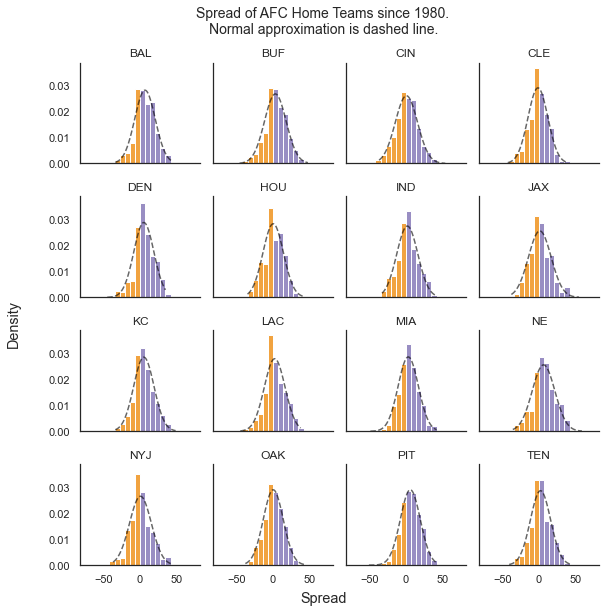

In [101]:
afc_df = df[(df.season > 1980) & (df.conference == 'AFC')]

afc = sns.FacetGrid(afc_df.sort_values('team1'), col="team1", col_wrap=4, height=2)
afc = (afc.map(color_coded_hist, "spread")
     .map(best_norm, "spread")
     .set_titles("{col_name}")
     .set_axis_labels('', '')
     .figure.supylabel('Density', x=-0.05)
     .figure.supxlabel('Spread')
     )

plt.suptitle('Spread of AFC Home Teams since 1980. \nNormal approximation is dashed line.', y=1.05, fontsize=14)
plt.show()

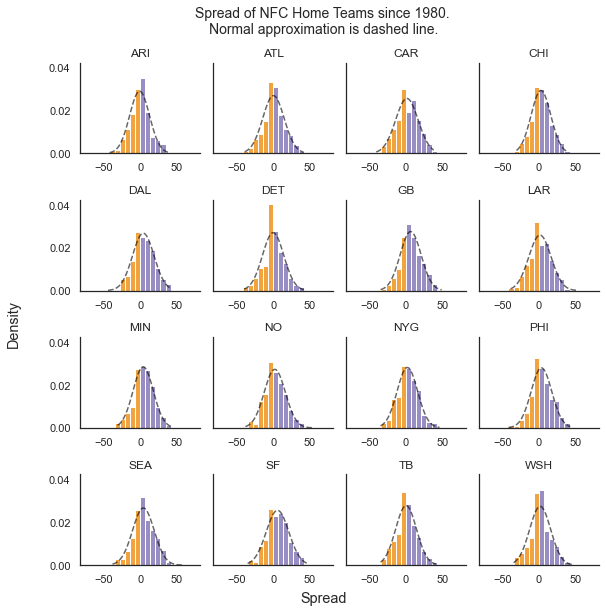

In [120]:
nfc_df = df[(df.season > 1980) & (df.conference == 'NFC')]

nfc = sns.FacetGrid(nfc_df.sort_values('team1'), col="team1", col_wrap=4, height=2, sharex=False)
nfc = (nfc.map(color_coded_hist, "spread")
     .map(best_norm, "spread")
     .set_titles("{col_name}")
     .set_axis_labels('', '')
     .figure.supylabel('Density', x=-0.05)
     .figure.supxlabel('Spread')
     )

plt.suptitle('Spread of NFC Home Teams since 1980. \nNormal approximation is dashed line.', y=1.05, fontsize=14)
plt.show()

In [133]:
# Ignore a future warning that comes from scipy.
import warnings
warnings.filterwarnings("ignore")

# Show some of the values
print("~ Overall ~")
print(df[df.neutral == 0][['spread', 'result1']].mean())
print("\n~ Past few seasons ~")
print(df[(df.neutral == 0) & (df.season > 2016)].groupby('season')[['spread', 'result1']].mean())


# Create a data frame with lagged rolling means and combine with the existing data
rolling_avg = (
    df.groupby('season')[['spread', 'result1']].mean()
    .rolling(3, min_periods=1)
    .mean()
    .shift(1)
)
rolling_avg['win_pct_advantage'] =  rolling_avg.result1 - .5
rolling_avg['spread_advantage'] = rolling_avg.spread
rolling_avg = rolling_avg.drop(columns=['result1', 'spread'])

~ Overall ~
spread     2.857403
result1    0.577328
dtype: float64

~ Past few seasons ~
          spread   result1
season                    
2017    2.639847  0.574713
2018    2.319392  0.600760
2019    0.091954  0.522989
2020    0.093284  0.498134
2021    1.811388  0.514235


Text(0.5, 1.0, 'Win Percent by Season — lagged moving average is dotted line')

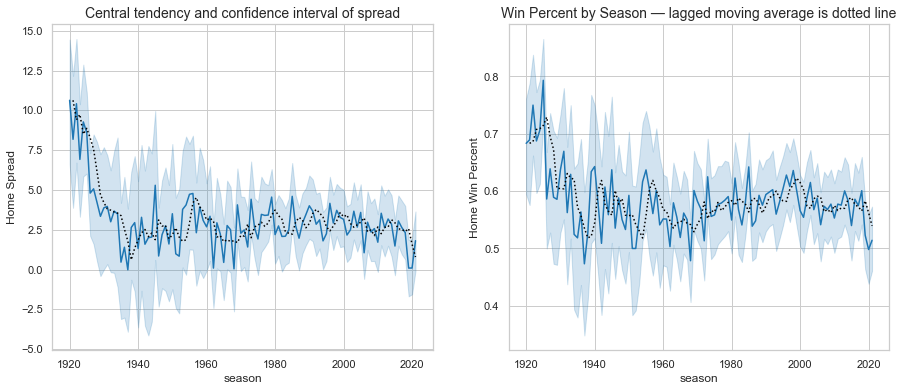

In [137]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15.0, 6.0)
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.lineplot(x='season', y='spread', data=df[df.neutral == 0], ax=ax1)
ax1.plot(rolling_avg.index, rolling_avg.spread_advantage, 'k:')
ax1.set_ylabel('Home Spread')
ax1.set_title('Central tendency and confidence interval of spread', fontsize=14)

sns.lineplot(x='season', y='result1', data=df[df.neutral == 0], ax=ax2)
ax2.plot(rolling_avg.index, rolling_avg.win_pct_advantage + .5, 'k:')
ax2.set_ylabel('Home Win Percent')
ax2.set_title('Win Percent by Season — lagged moving average is dotted line', fontsize=14)

### Convert from "by-game" to "by-team" format

The original FiveThirtyEight dataset has one row per game ("by-game" format), with the home team labelled as "team1." If I want to see all of the games for a single team progress I have to bounce between the "team1" and "team2" columns. Reshape the dataset to "by-team" format, meaning there are two rows per game, adding an extra column "home" to identify the home team. This way I can group by "season" and "team1" and have all of the games for each team. The new dataset will be called `by_team`.


<div style="display:flex;justify-content:center;align-items:center;">
    <table>
        <caption>by-game format: one row per game</caption>
        <tr><th>season</th><th>date</th><th>team1</th><th>team2</th><th>result1</th></tr>
        <tr><td>1985</td><td>1985-09-15</td><td>CHI</td><td>NE</td><td>1</td></tr>
        <tr><td>1985</td><td>1985-09-19</td><td>MIN</td><td>CHI</td><td>0</td></tr>
    </table>
    ⇨
    <table>
        <caption>by-team format: one row per team per game</caption>
        <tr><th>season</th><th>date</th><th>home</th><th>team1</th><th>team2</th><th>result1</th></tr>
        <tr><td>1985</td><td>1985-09-15</td><td>1</td><td>CHI</td><td>NE</td><td>1</td></tr>
        <tr><td>1985</td><td>1985-09-19</td><td>0</td><td>CHI</td><td>MIN</td><td>1</td></tr>
        <tr><td>1985</td><td>1985-09-15</td><td>0</td><td>NE</td><td>CHI</td><td>0</td></tr>
        <tr><td>1985</td><td>1985-09-19</td><td>1</td><td>MIN</td><td>CHI</td><td>0</td></tr>
    </table>
</div>

In [138]:
home_games = df[
    ['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'result1', 'spread']
    ][df.season > 1975]
home_games['home'] = 1

# Now swap the teams for "away"
away_games = home_games.rename(columns={'team1': 'team2', 'team2': 'team1'})
away_games['home'] = 1 - home_games.home
# Remember to switch the meaning of the winning and spread columns too
away_games['result1'] = 1 - home_games.result1
away_games['spread'] = - home_games.spread

by_team = (
    pd.concat([home_games, away_games], ignore_index=True)
    .sort_values(by=['season', 'team1', 'date'])
)

## Set up for iterative updating

Both the models will follow the same procedure:

1. Initialize the model with a baseline:
    1. Bernoulli win probability = 50%
    2. T-distribution spread = 0
2. After every game, update the hyperparameters with the new information as described in their respective formulas
3. Use the hyperparameters to calculate the posterior predictive distribution

Make a <span class="vocabulary" title="New in Python 3.4, the Abstract Base Class is Python's version of a Java Interface—a subclass must implement all of the @abstractmethod methods, or instances will fail with a TypeError on instantiation.">base class</span> that will keep track of all of the hyperparameters for each team and each game. The parameters can be added as columns to the main dataset for backtesting. In practice, the `Updater.lookup` attribute would be accessing a database, not a dictionary, and the update step would be run weekly to increment the hyperparameters based on the game results. But for this blog post, it will remain a dictionary.

In [139]:
from abc import ABC, abstractmethod
from collections import namedtuple

class Updater(ABC):
    def __init__(self, *hyperparameters):
        # Form of lookup:
        # {season: {team: [{week1 data}, {week2 data}, ... {weekN data}]}}
        self.lookup = {}
        self.Params = namedtuple('Params', ['date'] + list(hyperparameters))
        
    def iterrows(self):
        for season, teams in self.lookup.items():
            for team, results in teams.items():
                for row in results:
                    yield dict(season=season, team1=team, **row._asdict())
        
    def get_rows(self):
        return [r for r in self.iterrows()]
    
    @abstractmethod
    def revert_to_mean(self, season, team, keep=.3, n_obs=8):
        pass
    
    @abstractmethod
    def update(self, row):
        pass

## Bernoulli distribution

The probability of winning is equal to:

$$ \text{Pr}(\text{win}) = \frac{\alpha}{\alpha + \beta} \pm \text{home advantage} $$

The hyperparameters for the Bernoulli distribution are:

$$
\begin{aligned}
  \alpha &= 1 + \text{number of wins}  \\
  \beta &=  1 + \text{number of losses}
\end{aligned}
$$

Updates are done by this rule:

* A win increments $\alpha$ by 1
* A loss increments $\beta$ by 1
* A tie increments both $\alpha$ and $\beta$ by 0.5

The default initial value sets $\alpha = \beta$, where you can choose how many "observations" (`n_obs`) to pretend we have already seen. If `n_obs` is a large number, then the incremental effect of new games won't be as pronounced. If `n_obs` is a small number, then the new season's data will quickly overwhelm the past performance. I tuned the parameters for good performance:

* Weight $\alpha$ and $\beta$ at the beginning of each year as if they count for 4 games.
* Revert $\alpha$ and $\beta$ back to the mean ($\alpha = \beta$) keeping 80% of last year's final value.

In [140]:
class BernoulliUpdater(Updater):
    def __init__(self):
        super().__init__('alpha1', 'beta1')
        
    def revert_to_mean(self, season, team, keep=.8, n_obs=4):
        # default
        alpha = beta = 1 + n_obs * .5
        # or use existing data        
        if season in self.lookup and team in self.lookup[season]:
            last_entry = self.lookup[season][team].pop()
            date, alpha0, beta0 = last_entry
            p = alpha0 / (alpha0 + beta0)
            alpha = 1 + n_obs * (keep * p + (1 - keep) * .5)
            beta = 1 + n_obs * (keep * (1 - p) + (1 - keep) * .5)
            # push back the reverted value to the list
            self.lookup[season][team].append(self.Params(date, alpha, beta))
        return alpha, beta
            
    def update(self, row):
        if row.season not in self.lookup:
            self.lookup[row.season] = {}
        if row.team1 not in self.lookup[row.season]:
            self.lookup[row.season][row.team1] = []
            alpha, beta = self.revert_to_mean(row.season - 1, row.team1)
        else:
            __, alpha, beta = self.lookup[row.season][row.team1][-1]
        # THE UPDATE STEP:
        # a' = a + 1 if win else 0
        # b' = b + 1 if lose
        if row.result1 == 1:  # Won
            alpha_beta_next = self.Params(row.date, alpha + 1, beta)
        elif row.result1 == 0.5:  # Tie
            alpha_beta_next = self.Params(row.date, alpha + .5, beta + .5)
        else:  # Lost
            alpha_beta_next = self.Params(row.date, alpha, beta + 1)
        self.lookup[row.season][row.team1].append(alpha_beta_next)
        return alpha, beta


bernoulli_updater = BernoulliUpdater()
for i, row in by_team.iterrows():
    bernoulli_updater.update(row)

ab = pd.DataFrame(bernoulli_updater.get_rows()).sort_values(['team1','season'])
g = ab.groupby('team1')
ab = ab.assign(alpha1 = g.alpha1.shift(), beta1=g.beta1.shift())

bernoulli_dataset = (
    by_team[[c for c in by_team.columns if c != 'spread']]
    .merge(ab, on=['season', 'date', 'team1'])
    .reindex(columns=[
        'season', 'date', 'home', 'neutral', 'playoff',
        'team1', 'team2', 'result1', 'alpha1', 'beta1'])
)

### Convert back from "by-team" to "by-game" format 

We now have to convert back to the original layout of one row per game. The goal is to combine each team's performance to predict the outcome of the game: `team1`'s hyperparameters $\alpha_1$ and $\beta_1$ are combined with `team2`'s hyperparameters $\beta_1$ and $\beta_2$, so that overall the formula for win probability will be:

$$
\text{Pr}(\text{team}_1 \text{ wins}) =
   \frac{\alpha}{\alpha + \beta} + \text{team}_1\text{ home advantage}
$$

in which $\alpha = \left(\alpha_1 + \beta_2 - 1\right)$ and $ \beta = \left(\beta_1 + \alpha_2 - 1\right)$.

In [143]:
# use toggle
b = (
    bernoulli_dataset[['season', 'date', 'team1', 'alpha1', 'beta1']]
    .rename(columns=dict(team1='team2', alpha1='alpha2', beta1='beta2'))
    .merge(bernoulli_dataset, on=['season', 'date', 'team2'])
    .join(
        rolling_avg[['win_pct_advantage']]
        .rename(columns={'win_pct_advantage':'home_advantage'})
        , on='season')
)

b = (
    b.assign(
        pwin = 
        (b.alpha1 + b.beta2 - 1) / (b.alpha1 + b.beta1 + b.alpha2 + b.beta2 - 2)
        # if at home and not neutral add home advantage
        + b.home * (1 - b.neutral) * b.home_advantage
        # if away and not neutral subtract home advantage
        - (1 - b.home) * (1 - b.neutral) * b.home_advantage
        ,
        success = lambda row:  row.pwin.round() == row.result1
    )
    .reindex(columns=(
        list(bernoulli_dataset.columns)
        + ['alpha2', 'beta2', 'home_advantage', 'pwin', 'success']
    ))
)

print(b.success.mean())
b.tail()

0.6313529617946022


,season,date,home,neutral,playoff,team1,team2,result1,alpha1,beta1,alpha2,beta2,home_advantage,pwin,success
22819,2021,2021-12-12,0,0,0,DAL,WSH,1.0,10.715371,7.284629,8.686776,9.313224,0.039326,0.520339,True
22820,2021,2021-12-21,1,0,0,PHI,WSH,1.0,8.505916,10.494084,8.686776,10.313224,0.039326,0.534302,True
22821,2021,2021-12-26,1,0,0,DAL,WSH,1.0,12.715371,7.284629,8.686776,11.313224,0.039326,0.645341,True
22822,2021,2022-01-02,0,0,0,PHI,WSH,1.0,10.505916,10.494084,8.686776,12.313224,0.039326,0.506153,True
22823,2021,2022-01-09,1,0,0,NYG,WSH,0.0,6.613127,15.386873,8.686776,13.313224,0.039326,0.489953,True


### Check model performance

One way to visualize the performance of a binary classification model is with a <span class="vocabulary" title="Invented by electrical engineers in World War II, this chart is used to show what happens when you vary the cutoff in a predictive model that predicts a boolean outcome (in our case, the win probability). If you cut off at p=0%, then everything is a 'win', if you cut off at p=100%, everything is a 'loss', and at the cutoffs in between you get the curve.">Receiver operating characteristic</span> (ROC) plot (<a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">Wikipedia page</a>). The total area under the curve (AUC) can be used as a measure of model performance, with larger AUC identifying better models.

<div style="display:flex;justify-content:center;">
    <figure><figcaption>No effect</figcaption>
      <svg style="border:1px solid black" width="100" height="100" xmlns="http://www.w3.org/2000/svg"><path d="M 0 100 L 100 0" stroke="royalblue" stroke-width="3"></path></svg>
    </figure>
    <figure><figcaption>Mild effect</figcaption>
      <svg style="border:1px solid black" width="100" height="100" xmlns="http://www.w3.org/2000/svg"><path d="M 0 100 C 25 50 50 25 100 0" stroke="royalblue" stroke-width="3" fill="transparent"></path></svg>
    </figure>
    <figure><figcaption>Amazing</figcaption>
      <svg style="border:1px solid black" width="100" height="100" xmlns="http://www.w3.org/2000/svg"><path d="M 0 100 C 0 0 0 0 100 0" stroke="royalblue" stroke-width="3" fill="transparent"></path></svg>
    </figure>
</div>

Our best model with the this Bernoulli posterior has about 63% accuracy, and an area under the ROC curve of about 0.68. This is as good as my logistic regression models from prior years that incldued moving averages of penalties, turnovers, and passing and rushing yards. Cool.

In [144]:
def plot_roc(predicted, actual, resolution=100, ax=None):
    """'predicted' and 'actual' are pandas Series."""
    ax = ax or plt.gca()
    cutoff = np.linspace(0, 1, resolution)
    total_pos = (actual == 1).sum()
    total_neg = (actual != 1).sum()
    true_positive_rate = np.fromiter(
        map(lambda c: (actual[predicted > c] == 1).sum() / total_pos, cutoff),
        float)
    false_positive_rate = np.fromiter(
        map(lambda c: (actual[predicted > c] != 1).sum() / total_neg, cutoff),
        float)
    ax.plot(
        false_positive_rate, true_positive_rate,
        linestyle='-', color=sns.color_palette()[0], linewidth=3)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot([0,1], [0,1], 'k:')
    # Area under the curve
    auc = sum((true_positive_rate[:-1] + true_positive_rate[1:]) / 2
              * (false_positive_rate[:-1] - false_positive_rate[1:]))
    ax.set_title('ROC curve. AUC = {:0.3f}'.format(auc), fontsize=14);

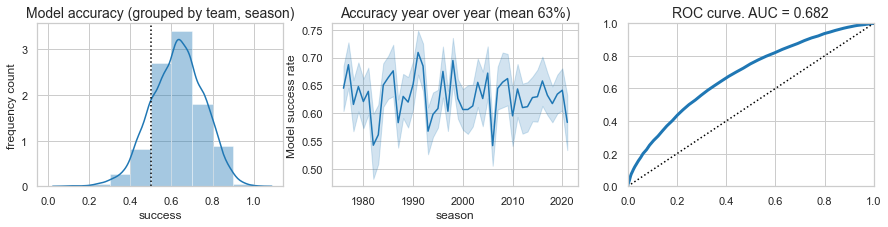

In [145]:
## Start the actual plot
plt.rcParams['figure.figsize'] = (15.0, 3.0)
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

summary = b.groupby(['team1', 'season'], as_index=False).success.mean()

# Histogram
sns.distplot(summary.success, ax=ax1, bins=np.linspace(0, 1, 11))
ax1.axvline(0.5, color='k', linestyle=':')
ax1.set_ylabel("frequency count")
ax1.set_title('Model accuracy (grouped by team, season)', fontsize=14)

# Time series
sns.lineplot(x="season", y="success", data=summary, ax=ax2)
ax2.set_ylabel("Model success rate")
ax2.set_title('Accuracy year over year (mean {:0.0%})'.format(b.success.mean()), fontsize=14)

# ROC
plot_roc(b.pwin, b.result1, resolution=100, ax=ax3)

## T distribution

This section is based on the content of <a href="https://en.wikipedia.org/wiki/Conjugate_prior#Continuous_distributions">this table</a> on the Wikipedia page for conjugate priors. The spread follows a T distribution with parameters:

$$
\text{Pr}(\text{spread}) = t_{2\alpha}\left(\tilde{\text{spread}} | \mu, \sigma^2 = \frac{\beta (\nu + 1)}{\alpha\nu}\right)
$$

The hyperparameters for the T distribution are:

$$
\begin{aligned}
    \nu &= \text{number of games} \\
    \mu &= \text{running mean of spread} \\
    \alpha &= \nu / 2 \\
    \beta &= (\text{running sum of the squared deviations}) / 2
\end{aligned}
$$

Updates are done by these rules:

* Increment $\nu$ each game, $\nu' = \nu + 1$
* Intermediate variable $\delta = x - \mu$
* The running mean is $\mu' = \mu + \delta / \nu'$
* The running sum of squared deviations is $2\beta = 2\beta + \delta * \mu'$


The default initial value sets $\mu = 0$, and the number of observations `n_obs` to 3. The parameters for mean reversion were tuned for good performance and are:

* Set $\nu$ to 3 games.
* Revert $\mu$ back to zero keeping 50% of last year's final value.
* Revert $\beta$ back to the mean $\beta$ of all teams in the prior year, scaled down to 3 games. Keep 50% of last year's final value.

In [146]:
class TUpdater(Updater):
    def __init__(self):
        super().__init__('nu1', 'mu1', 'alpha1', 'beta1')
        
    def get_mean_beta(self, season):
        mean_beta = 16**2 / 2  # Default
        if season in self.lookup:
            team_sets = self.lookup[season].values()
            mean_beta = (
                sum(ts[-1].beta1 for ts in team_sets)
                / sum(ts[-1].nu1 for ts in team_sets))
        return mean_beta
        
    def revert_to_mean(self, season, team, keep=.5, n_obs=3):
        mean_beta = self.get_mean_beta(season - 1)  # Default
        nu, mu, alpha, beta = n_obs, 0, n_obs / 2, mean_beta * n_obs
        # or use existing data
        if season in self.lookup and team in self.lookup[season]:
            last_entry = self.lookup[season][team].pop()
            date, nu0, mu0, alpha0, beta0 = last_entry
            mu = keep * mu0
            beta = nu * (keep * beta0 / nu0 + (1 - keep) * mean_beta)
            # push back the reverted value to the list
            self.lookup[season][team].append(self.Params(date, nu, mu, alpha, beta))
        return nu, mu, alpha, beta
            
    def update(self, row):
        if row.season not in self.lookup:
            self.lookup[row.season] = {}
        if row.team1 not in self.lookup[row.season]:
            self.lookup[row.season][row.team1] = []
            nu, mu, alpha, beta = self.revert_to_mean(row.season - 1, row.team1)
        else:
            __, nu, mu, alpha, beta = self.lookup[row.season][row.team1][-1]
        # THE UPDATE STEP:
        delta = row.spread - mu
        nu_mu_alpha_beta_next = self.Params(
            row.date,
            nu + 1,                       # nu' = nu + 1
            mu + delta / (nu + 1),        # mu' = mu + delta / (nu + 1)
            alpha + .5,                   # alpha' = alpha + 1/2
            beta + delta * (mu + delta / (nu + 1)) / 2
                                          # beta' = beta + delta * mu' / 2
        )
        self.lookup[row.season][row.team1].append(nu_mu_alpha_beta_next)
        return nu, mu, alpha, beta

t_updater = TUpdater()
for i, row in by_team.iterrows():
    t_updater.update(row)

nmab = pd.DataFrame(t_updater.get_rows()).sort_values(['team1','season'])
g = nmab.groupby('team1')
nmab = nmab.assign(
    nu1 = g.nu1.shift(),
    mu1 = g.mu1.shift(),
    alpha1 = g.alpha1.shift(),
    beta1=g.beta1.shift())

t_dataset = (
    by_team[[c for c in by_team.columns if c != 'result1']]
    .merge(nmab, on=['season', 'date', 'team1'])
    .reindex(columns=[
        'season', 'date', 'home', 'neutral', 'playoff',
        'team1', 'team2', 'spread', 'nu1', 'mu1', 'alpha1', 'beta1'])
)

### Convert back from "by-team" to "by-game" format 

We will again convert back to the original layout of one row per game. Combining the two teams' hyperparameters is a little more complicated than for the Bernoulli distribution. The distribution of the spread will be:

$$
\text{Pr}(\text{team}_1 \text{ spread}) =
   t_{2\alpha}\left(\tilde{\text{spread}} | \mu, \sigma^2 = \frac{\beta (\nu + 1)}{\alpha\nu}\right)
$$

in which

$$
\begin{aligned}
  \nu &= \nu_1 + \nu_2 \\
  \alpha &= \alpha_1 + \alpha_2 \\
  \mu &= \frac{\nu_1 \mu_1 - \nu_2 \mu_2}{\nu_1 + \nu_2} \\
  \beta &= \beta_1 + \beta_2 + \frac{\nu_1 \nu_2}{\nu_1 + \nu_2} \frac{(\mu_1 + \mu_2)^2}{2}
\end{aligned}
$$

In [147]:
t = (
    t_dataset[['season', 'date', 'team1', 'nu1', 'mu1', 'alpha1', 'beta1']]
    .rename(columns=dict(
        team1='team2', nu1='nu2', mu1='mu2', alpha1='alpha2', beta1='beta2'))
    .merge(t_dataset, on=['season', 'date', 'team2'])
    .join(
        rolling_avg[['spread_advantage']]
        .rename(columns={'spread_advantage':'home_advantage'})
        , on='season')
)

t = (
    t.assign(
        pspread =
            (t.nu1 * t.mu1 - t.nu2 * t.mu2) / (t.nu1 + t.nu2)
            # if at home and not neutral add home advantage
            + t.home * (1 - t.neutral) * t.home_advantage
            # if away and not neutral subtract home advantage
            - (1 - t.home) * (1 - t.neutral) * t.home_advantage
        ,
        betaprime =
            t.beta1 + t.beta2
            + (t.nu1 * t.nu2) / (t.nu1 + t.nu2)
            * (t.mu1 + t.mu2)**2 / 2
        ,
        pwin = (
            lambda row: 1 - stats.t.cdf(
                0,
                row.nu1 + row.nu2,
                loc=row.pspread,
                scale=(
                    row.betaprime
                    * (row.nu1 + row.nu2 + 1)
                    / (row.nu1 + row.nu2) / (row.alpha1 + row.alpha2)
                )))
        ,
        success = lambda row: row.pwin.round() == (row.spread > 0)
    )
    .reindex(columns=(
        list(t_dataset.columns)
        + ['nu2', 'mu2', 'alpha2', 'beta2', 'home_advantage', 'pspread', 'pwin', 'success']
    ))
)

print(t.success.mean())
print(t.shape)
t.tail()

0.6356466876971609
(22824, 20)


,season,date,home,neutral,playoff,team1,team2,spread,nu1,mu1,alpha1,beta1,nu2,mu2,alpha2,beta2,home_advantage,pspread,pwin,success
22819,2021,2021-12-12,0,0,0,DAL,WSH,7,15.0,5.370097,7.5,133.812914,15.0,-3.479252,7.5,39.393905,0.784832,3.639842,0.610490,True
22820,2021,2021-12-21,1,0,0,PHI,WSH,10,16.0,2.469784,8.0,154.021316,16.0,-3.699299,8.0,45.906054,0.784832,3.869374,0.613711,True
22821,2021,2021-12-26,1,0,0,DAL,WSH,42,17.0,6.032439,8.5,167.010941,17.0,-4.069928,8.5,58.727755,0.784832,5.836016,0.653469,True
22822,2021,2022-01-02,0,0,0,PHI,WSH,4,18.0,4.084252,9.0,208.050937,18.0,-6.177155,9.0,175.877714,0.784832,4.345871,0.574253,True
22823,2021,2022-01-09,1,0,0,NYG,WSH,-15,19.0,-7.883748,9.5,290.860688,19.0,-6.062568,9.5,169.278140,0.784832,-0.125758,0.499333,True


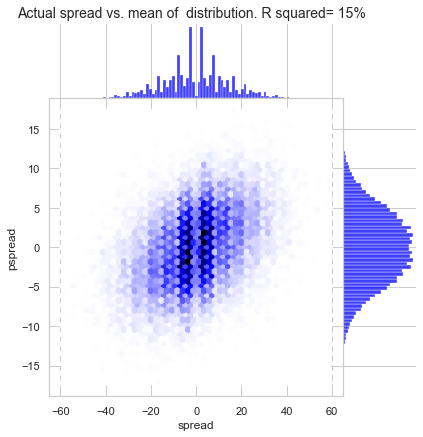

In [148]:
# use toggle
ss_res = ((t.spread - t.pspread)**2).sum()
ss_tot = ((t.spread - t.spread.mean())**2).sum()
r_squared = 1 -  ss_res/ ss_tot
sns.jointplot("spread", "pspread", data=t, kind="hex", space=0, color="b", ratio=4)
title = "Actual spread vs. mean of  distribution. R squared= {:0.0%}".format(r_squared)
plt.suptitle(title, x=.45, y=1.01, fontsize=14)

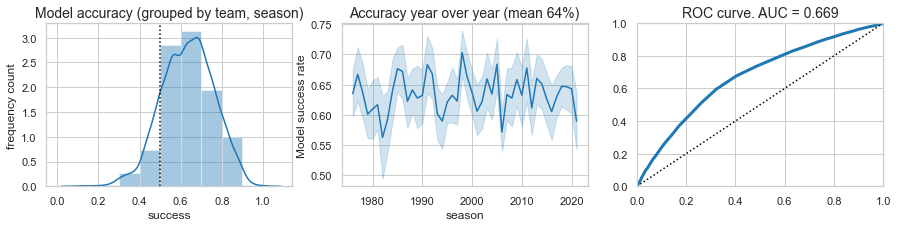

In [149]:
# use toggle
plt.rcParams['figure.figsize'] = (15.0, 3.0)
f, ax = plt.subplots(1, 3)

summary = t.groupby(['team1', 'season'], as_index=False).success.mean()

# Histogram
sns.distplot(summary.success, ax=ax[0], bins=np.linspace(0, 1, 11))
ax[0].axvline(0.5, color='k', linestyle=':')
ax[0].set_ylabel("frequency count")
ax[0].set_title('Model accuracy (grouped by team, season)', fontsize=14)

# Time series
sns.lineplot(x="season", y="success", data=summary, ax=ax[1])
ax[1].set_ylabel("Model success rate")
ax[1].set_title('Accuracy year over year (mean {:0.0%})'.format(t.success.mean()), fontsize=14)

# ROC
plot_roc(t.pwin, t.spread > 0, resolution=100, ax=ax[2])

### References

* <a href="https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions">Bernoulli distribution conjugate prior</a>—Wikipedia's table of discrete conjugate priors. The table lists the parameters and how to update them.
* <a href="https://en.wikipedia.org/wiki/Conjugate_prior#Continuous_distributions">Normal distribution conjugate prior</a>—Also Wikipedia. For continuous distributions.  
* <a href="https://fivethirtyeight.com/features/how-our-2017-nfl-predictions-work/">FiveThirtyEight's NFL Elo rankings, explained</a>—Also sign up for their <a href="https://projects.fivethirtyeight.com/2018-nfl-forecasting-game/">NFL forecasting game</a>, and check out their <a href="https://github.com/fivethirtyeight/nfl-elo-game">GitHub repo</a>.
* <a href="https://nflpickwatch.com/">NFL Pickwatch</a>—The best forecasters' picks, aggregated in one site.
* <a href="https://www.pro-football-reference.com/">Pro-Football Reference</a>—One of the easiest sites to use for football statistics, including a frequently-updated <a href="https://www.pro-football-reference.com/players/injuries.htm">injury list</a>.
* <a href="http://pklab.net/?id=377&lang=EN">Single-pass variance blog post (no https)</a>—The first blog to actually cite Knuth while giving the algorithm gets my linkback.

*All links in this post were accessed on or before September 9, 2018.*